# Euler Characteristic Curves on the TOSCA data set
### Author: Matt Piekenbrock 

The _TOSCA_ data set consists of hi-resolution three-dimensional nonrigid shapes in a variety of poses. It comprises about 80 non-rigid shapes ("meshes"), which were used for similarity and correspondence experiments in the book "Numerical Geometry of Non-rigid Shapes" by Alex/Michael Bronstein and Ron Kimmel (Monographs in Computer Science).

### Dependencies
- NumPy + Scipy 
- Matplotlib + Bokeh for plotting models 
- Pymeshlab for curvature calculations

Function to load in TOSCA data set 

In [1]:
import numpy as np
import scipy.io
import requests

def tosca():
    import tarfile
    from urllib.request import urlopen
    from io import BytesIO
    url = "https://raw.githubusercontent.com/peekxc/tosca_signatures/main/tosca.tar.xz"
    tosca_file = tarfile.open(fileobj=BytesIO(urlopen(url).read()) , mode="r:xz")
    tosca_files = [name[:-4] for name in tosca_file.getnames() if name[0] != "."]
    def _extract_model(model_name: str, obj_id: str = None, normalize: bool = True):
        fn = (model_name + str(obj_id) + ".mat") if obj_id is not None else (model_name + ".mat")
        m = tosca_file.extractfile(fn)
        mat = scipy.io.loadmat(BytesIO(m.read()))
        x = np.ravel(mat['surface']['X'][0][0]).astype(float)
        y = np.ravel(mat['surface']['Y'][0][0]).astype(float)
        z = np.ravel(mat['surface']['Z'][0][0]).astype(float)
        S = np.c_[x,y,z]
        T = mat['surface']['TRIV'][0][0] - 1 # TOSCA is 1-based 
        if normalize:
            S -= S.mean(axis=0)
            c = np.linalg.norm(S.min(axis=0) - S.max(axis=0))
            S *= (1/c)
        return S, T
    return _extract_model, tosca_files

`tosca()` returns 1) a function which can load models and 2) the set of available model names in the data set  

In [2]:
get_tosca_model, model_names = tosca()

For example, to see the mesh corresponding to `wolf1` we can use:

In [3]:
X, T = get_tosca_model("wolf1")  
# Usage:
# get_tosca_model("wolf1")  
# or
# get_tosca_model("wolf", 1)

This returns a tuple (`X`, `T`) where `X`=vertex_coordinates and `T`=triangle_indices.

---

Below is code to grab a random set of models and plot their scatter plots

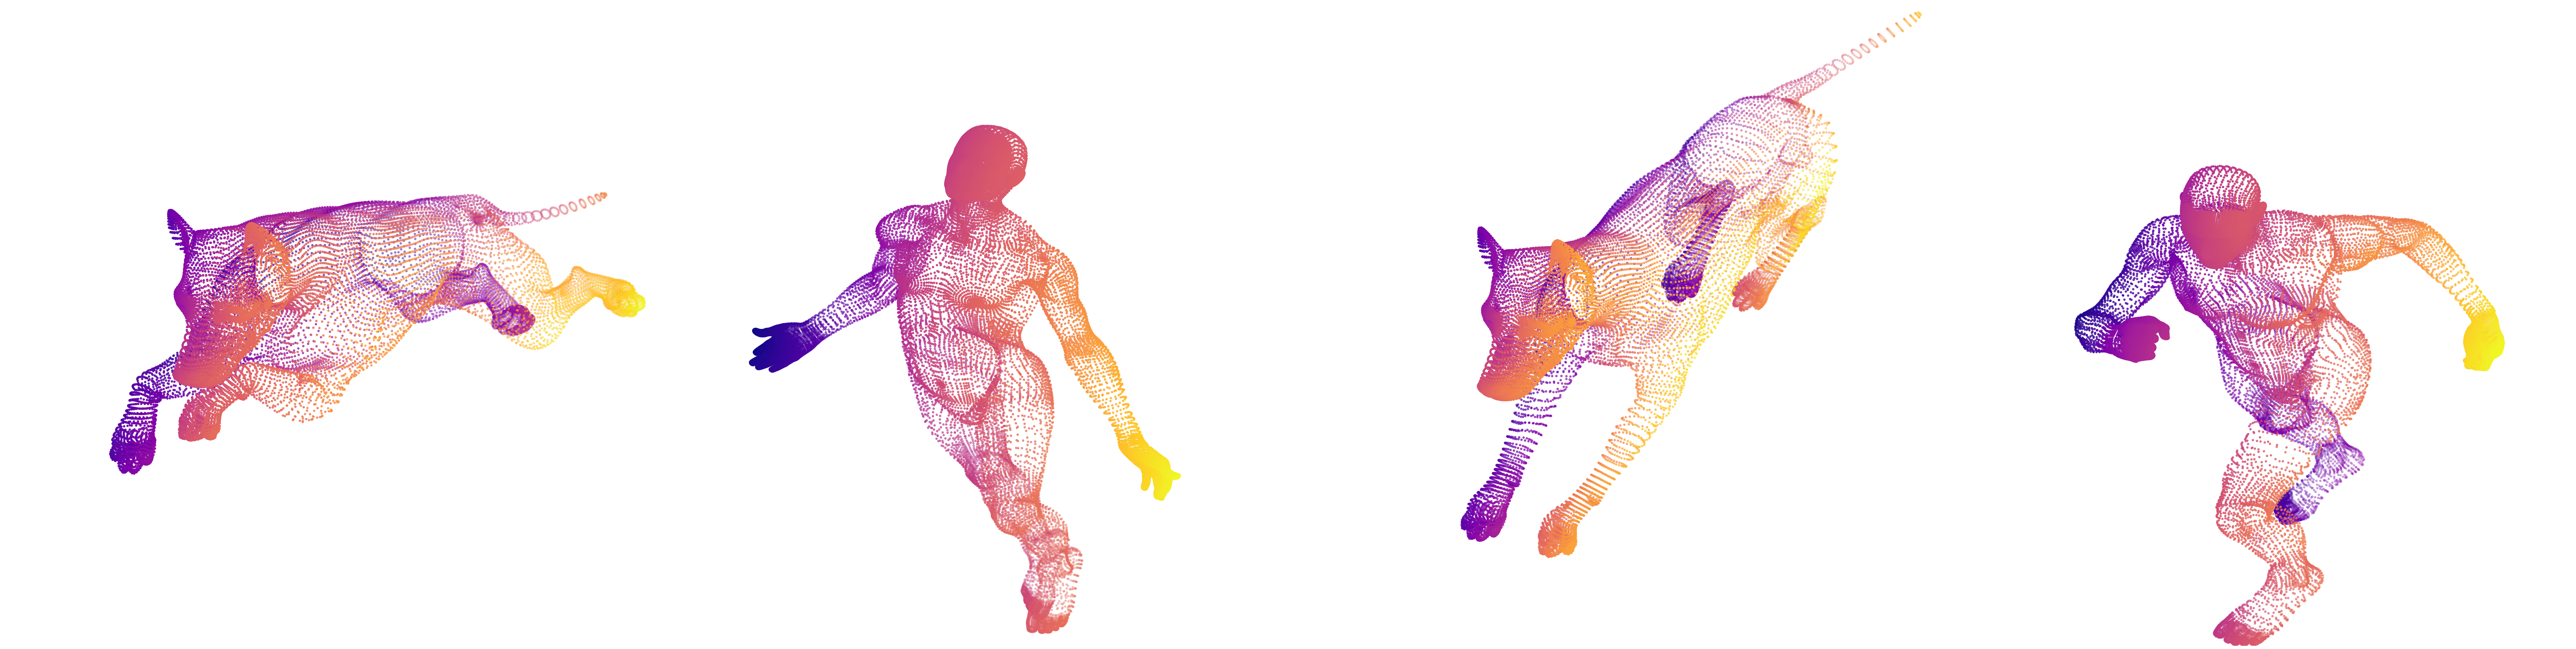

In [4]:
import matplotlib.pyplot as plt
from itertools import product
np.random.seed(234)
nrow, ncol = 1, 4
zoom = 0.25
tosca_models = np.random.choice(model_names, size=nrow*ncol, replace=False)

fig, axs = plt.subplots(nrow, ncol, figsize=(80, 30), subplot_kw={'projection': '3d'})
idx_iter = range(nrow*ncol)
for model_name, i in zip(tosca_models, idx_iter):
    X, T = get_tosca_model(model_name)
    c, rng = X.mean(axis=0), max(abs(X.max(axis=0)-X.min(axis=0)))
    axs[i].scatter(*X.T, s=18, c=X[:,0], cmap='plasma')
    axs[i].set_xlim(c[0] - zoom*rng, c[0] + zoom*rng)
    axs[i].set_ylim(c[1] - zoom*rng, c[1] + zoom*rng)
    axs[i].set_zlim(c[2] - zoom*rng, c[2] + zoom*rng)
    axs[i].axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)  

## Euler Characteristic Curves 

The Euler characteristic of a 2-dimensional mesh $X$ is defined as:
$$ \chi(X) = V - E + F $$
where ($V$, $E$, $T$) denotes the number vertices, edges, and triangles, respectively. 

If $X$ is filtered at various parameter values $T = \{ t_1, t_2, \dots, t_m \}$, such that $ \emptyset \subseteq X_{t_1} \subseteq X_{t_2} \subseteq \dots \subseteq X_{t_{m-1}} \subseteq X_{t_m} = X $, the _euler characteristic curve_ $\chi_T(X)$ is the sequence 
$$ \chi_T(X) = \{ \; \chi(X_{t_1}), \; \chi(X_{t_2}), \; \dots, \; \chi(X_{t_m}) \; \}$$
Since computing $\chi(X)$ takes $O(n)$ time where $n = \lvert X \rvert$, one may compute $\chi_T(X)$ naively in $O(nm)$ time. It turns out there is a simple algorithm that takes only $O(n + m)$.

In [5]:
from numpy.typing import ArrayLike 
from typing import Collection, Union

def euler_curve(X: ArrayLike, T: ArrayLike, f: ArrayLike, bins: Union[int, Collection[float]] = 20, method: str = ["simple", "top_down", "top_down_vec"]) -> ArrayLike:
    """Calculates the euler characteristic curve.

    Parameters:
        X = (n x 3) array of vertex coordinates 
        T = (m x 3) array of triangle indices 
        f = array of vertex values to filter by 
        bins = number of bins, or a sequence of threshold values 
        method = string indicating which method to use to compute the curve. Defaults to "simple". 

    Returns: 
        array of euler characteristic values of the mesh along _bins_ 
    """
    assert isinstance(X, np.ndarray) and X.ndim == 2, "Invalid point cloud given."
    assert isinstance(T, np.ndarray) and T.ndim == 2 and T.shape[1] == 3, "Invalid triangles given."
    f = np.array(f)
    assert isinstance(f, np.ndarray) and len(f) == X.shape[0], "Invalid vertex function array given."
    bins = np.linspace(min(f), max(f)+10*np.finfo(float).eps, bins) if isinstance(bins, int) else bins
    assert isinstance(bins, Collection), f"Invalid argument bins={bins}"
  
    ## Choose the euler invariant 
    if isinstance(method, list) or method == "simple" or method is None:
        ## Vectorized O(nm) approach
        E = np.array(list(set([tuple(e) for e in T[:,[0,1]]]) | set([tuple(e) for e in T[:,[0,2]]]) | set([tuple(e) for e in T[:,[1,2]]])))
        fe = f[E].max(axis=1)
        ft = f[T].max(axis=1)
        ecc = np.array([sum(f < t) - sum(fe < t) + sum(ft < t) for t in bins])
    elif method == "top_down": 
        ## O(n + m) approach from "Efficient classification using the Euler characteristic" vectorized using hirola 
        from itertools import combinations
        from hirola import HashTable
        ft = f[T].max(axis=1)
        vw = np.ones(len(f))*(-np.inf)
        np.maximum.at(vw, T.T, ft)
        h = HashTable((3*T.shape[0])*1.25, dtype=(T.dtype, 2))
        h.add(np.vstack((T[:,[0,1]], T[:,[0,2]], T[:,[1,2]])))
        ew = np.ones(h.length)*(-np.inf)
        np.maximum.at(ew, h[T[:,[0,1]]], ft)
        np.maximum.at(ew, h[T[:,[0,2]]], ft)
        np.maximum.at(ew, h[T[:,[1,2]]], ft)
        v_counts = np.cumsum(np.histogram(vw, bins=bins)[0])
        e_counts = np.cumsum(np.histogram(ew, bins=bins)[0])
        t_counts = np.cumsum(np.histogram(ft, bins=bins)[0])
        ecc = np.append(0, (v_counts - e_counts + t_counts))
    else: 
        raise ValueError(f"Unknown method {method}")
    return ecc

In [6]:
print(euler_curve(X, T, X @ np.array([1,0,0]), method="simple"))
print(euler_curve(X, T, X @ np.array([1,0,0]), method="top_down"))

[     0   -246   -831  -2300  -4239  -6105  -8213 -15581 -21474 -29635
 -39950 -46003 -47955 -49573 -50169 -50487 -50635 -51603 -56049 -58833]
[     0   -414  -1420  -4063  -7407 -10655 -14391 -28023 -39000 -53219
 -51185 -53312 -52690 -51587 -48773 -49191 -49377 -50458 -55593 -58866]


In [7]:
import timeit 
print(timeit.timeit(lambda: euler_curve(X, T, X @ np.array([1,0,0]), method="simple"), number=5))
print(timeit.timeit(lambda: euler_curve(X, T, X @ np.array([1,0,0]), method="top_down"), number=5))

5.617245799999999
0.1762984000000003


Small amount of preprocessing to group up model ids by class name and give them default colors

In [8]:
import re 
cls_rgx = re.compile(r"^([a-zA-Z]+)(\d+)") ## class regex 
tosca_classes = ['dog', 'cat', 'michael', 'centaur', 'victoria', 'horse', 'david', 'gorilla', 'wolf'] 
tosca_colors = ['red', 'blue', 'black', 'orange', 'yellow', 'green', 'purple', 'pink', 'cyan']
tosca_class_ids = { cls_nm : [] for cls_nm in  tosca_classes}
for fn in model_names:
    cls_nm, model_id = cls_rgx.split(fn)[1:3] 
    tosca_class_ids[cls_nm].append(int(model_id))

import pprint
pprint.PrettyPrinter(indent=2, compact=True).pprint(tosca_class_ids)

{ 'cat': [0, 1, 10, 2, 3, 4, 5, 6, 7, 8, 9],
  'centaur': [0, 1, 2, 3, 4, 5],
  'david': [0, 1, 10, 11, 12, 13, 6],
  'dog': [0, 1, 10, 2, 3, 5, 6, 7, 8],
  'gorilla': [1, 14, 5, 8],
  'horse': [0, 10, 14, 15, 17, 5, 6, 7],
  'michael': [ 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 3, 4, 5, 6, 7,
               8, 9],
  'victoria': [0, 1, 10, 12, 17, 2, 21, 23, 24, 25, 4, 7],
  'wolf': [0, 1, 2]}


In [1]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# tosca_subset = np.random.choice(tosca_classes, size = 4, replace=False)
tosca_subset = ["dog", "cat", "horse", "centaur", "victoria"]
bins = 20
INDEX = np.arange(bins)

p = figure(width=450, height=250, x_axis_label="Height index", y_axis_label="Euler Characteristic")
for tc in tosca_subset: 
    for model_id in tosca_class_ids[tc]:
        X, T = get_tosca_model(tc, model_id)
        f = X @ np.array([0,0,1])
        ecc = euler_curve(X, T, f, method="top_down")
        p.line(INDEX, ecc, color=tosca_colors[tosca_classes.index(tc)], legend_label=tc)
p.legend.location = "bottom_left"
show(p)


Loading BokehJS ...

NameError: name 'np' is not defined

## Using geometric information / curvature

The principal curvatures $\kappa_1$ and $\kappa_2$ form the basis of many geometric shape descriptors. For example, the Gaussian and mean curvature $K$ and $H$, respectively, defined as:

$$ K = \kappa_1  \kappa_2, \quad H = (\kappa_1 + \kappa_2)/2 $$

A more popular shape descriptor used in practice that is scale-invariant and very intuitive is the _shape index_ $s$, given by:

$$ s = \frac{2}{\pi} \mathrm{arctan} \frac{\kappa_2 + \kappa_1}{\kappa_2 - \kappa_1}, \quad \kappa_1 \geq \kappa_2 $$

In [ ]:
import pymeshlab
def curvature(
    X: ArrayLike, 
    T: ArrayLike, 
    value=["mean", "gaussian", "min", "max", "shape_index", "curvedness"], 
    fit=['Quadric Fitting', 'Normal Cycles', 'Taubin approximation']
) -> ArrayLike:
    """uses pymeshlab to compute the principal directions of curvature with different algorithms. 
  
    Parameters: 
        X = (n x 3) array of vertex coordinates 
        T = (m x 3) array of triangle indices 
        value = type of curvature to compute. 
        fit = algorithm to fit the curvature by. 

    Returns: 
        array of curvature values at the mesh vertices.

    Note: This function can fail if the mesh has non-unique vertices

    See: https://pymeshlab.readthedocs.io/en/2021.10/filter_list.html#compute_curvature_principal_directions for more details. 
    """ 
    fit_method = {'quadric fitting' : 3, 'normal cycles' : 2, 'taubin approximation' : 0 }
    value_type = {'mean': 0, 'gauss': 1, 'min': 2, 'max': 3, 'shape_index': 4, 'curvedness': 5 }
    value = 'shape_index' if isinstance(value, list) else str(value).tolower()
    fit = 'quadric fitting' if isinstance(fit, list) else str(fit).tolower()
    assert isinstance(fit, str) and fit in fit_method.keys(), f"Invalid fit method '{fit}' given."
    assert isinstance(value, str) and value in value_type.keys(), f"Invalid curvature type '{value}' given."
    ms = pymeshlab.MeshSet()
    ms.add_mesh(pymeshlab.Mesh(X, T))
    ms.compute_curvature_principal_directions_per_vertex(method=3, curvcolormethod=4)
    mesh = ms.mesh(0)
    return mesh.vertex_scalar_array()

In [ ]:
np.random.seed(234)
nrow, ncol = 1, 4
zoom = 0.25
tosca_models = np.random.choice(model_names, size=nrow*ncol, replace=False)

fig, axs = plt.subplots(nrow, ncol, figsize=(80, 30), subplot_kw={'projection': '3d'})
idx_iter = range(nrow*ncol)
for model_name, i in zip(tosca_models, idx_iter):
    X, T = get_tosca_model(model_name)
    c, rng = X.mean(axis=0), max(abs(X.max(axis=0)-X.min(axis=0)))
    f = curvature(X, T)
    axs[i].scatter(*X.T, s=80, c=f, cmap='plasma')
    axs[i].set_xlim(c[0] - zoom*rng, c[0] + zoom*rng)
    axs[i].set_ylim(c[1] - zoom*rng, c[1] + zoom*rng)
    axs[i].set_zlim(c[2] - zoom*rng, c[2] + zoom*rng)
    axs[i].axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0) 


In [ ]:
tosca_subset = ["michael", "david", "victoria", "dog"]
p = figure(width=450, height=250, x_axis_label="Sublevel sets of Shape Index", y_axis_label="Euler Characteristic")
for tc in tosca_subset:
    for model_id in tosca_class_ids[tc]:
        X, T = get_tosca_model(tc, model_id)
        f = curvature(X, T)
        ecc = euler_curve(X, T, f, method="top_down")
        p.line(INDEX, ecc, color=tosca_colors[tosca_classes.index(tc)], legend_label=tc)
p.legend.location = "bottom_left"
show(p)